In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [3]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = ps.fuseCategoricalFeatures(train[categorical_fs])
ordinals = train[other_fs[1:-1]]
target = train.target

In [4]:
ordinals.columns

Index(['ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03',
       'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02'],
      dtype='object')

In [5]:
class1_freq = np.sum(target)/len(target)
class1_freq

0.036447517859182946

### 1. Version with statsmodels.nonparametric.KDEUnivariate

In [6]:
def estimate_KD1(feature, target, target_class=1, ax=None, 
                  kernel='gau', bw='normal_reference', fft=True, hist_bins='auto'):
    '''
    Estimate kernel density with statsmodels.nonparametric.KDEUnivariate
    '''
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    target_classes = feature[target == target_class]
    print(feature.shape)
    print(target_classes.shape)
    
    bulk_kde = sm.nonparametric.KDEUnivariate(feature.astype('float'))
    bulk_kde.fit(kernel=kernel, bw=bw, fft=fft)
    
    class_kde = sm.nonparametric.KDEUnivariate(target_classes.astype('float'))
    class_kde.fit(kernel=kernel, bw=bw, fft=fft)
    
    if hist_bins == 'auto':
        bins = len(feature.unique())
    elif type(hist_bins) == 'int':
        bins = hist_bins
    elif type(hist_bins == 'float'):
        bins = int(hist_bins)
    else:
        print('Error: bins must be an integer')
              
    ax.hist(feature, bins=bins, normed=True, color='skyblue', alpha=0.5, label=None)
    ax.plot(bulk_kde.support, bulk_kde.density, color='skyblue', ls='--', label='Bulk')

    ax.hist(target_classes, bins=bins, normed=True, color='red', alpha=0.2, label=None)
    ax.plot(class_kde.support, class_kde.density, color='red', alpha=0.2, ls='--', label='Target Class')
    
    ax.legend(loc='upper right')
    
    return bulk_kde, class_kde

def compare_KDE3(kde1, kde2, span, level=1, label=None):
    kde1_size = len(kde1.density)
    kde2_size = len(kde2.density)
    density1 = kde1_size* kde1.evaluate(span)
    density2 = kde2_size* kde2.evaluate(span)
    cond_proba_class1_given_val = density2 / density1
    percent_gain = 100*((cond_proba_class1_given_val/level) - 1)
    plt.axhline(y=1, color='0.8', ls='--')
    plt.plot(span, percent_gain, label=label)
    plt.ylabel('%% Gain from Bulk Class1 Freq')
    #plt.ylim([0, 1.1*np.max(percent_gain)])
    return

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


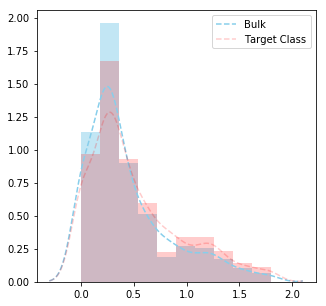

In [7]:
bulkKDE, classKDE = estimate_KD1(ordinals['ps_reg_02'], target, target_class=1, ax=None, 
                                 kernel='gau', bw=0.1, fft=True, hist_bins=10)

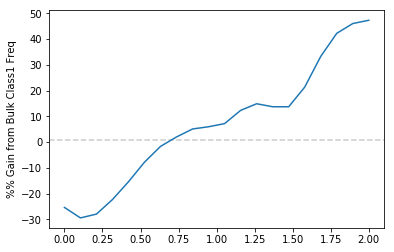

In [8]:
compare_KDE3(bulkKDE, classKDE, np.linspace(0, 2, 20), level=class1_freq, label=None)

### 2. Version with sklearn.neighbors.KernelDensity

In [9]:
def estimate_KD2(feature, target, target_class=1, ax=None, span='auto',
                 bandwidth=1, algorithm='auto', kernel='gaussian', metric='euclidean',
                 atol=0, rtol=0, breadth_first=True, leaf_size=40, metric_params=None, 
                 hist_bins='auto'):
    '''
    Estimate kernel density with statsmodelsKDEUnivariate 
    '''
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    target_classes = feature[target == target_class]
    print(feature.shape)
    print(target_classes.shape)
    
    bulk_kde = KernelDensity(bandwidth=bandwidth, algorithm=algorithm, kernel=kernel, metric=metric,
                             atol=atol, rtol=rtol, breadth_first=breadth_first, leaf_size=leaf_size, 
                             metric_params=metric_params)
    bulk_kde.fit(np.array(feature).reshape(-1, 1))
    
    class_kde = KernelDensity(bandwidth=bandwidth, algorithm=algorithm, kernel=kernel, metric=metric,
                             atol=atol, rtol=rtol, breadth_first=breadth_first, leaf_size=leaf_size, 
                              metric_params=metric_params)
    class_kde.fit(np.array(target_classes).reshape(-1, 1))
    
    if hist_bins == 'auto':
        bins = len(feature.unique())
    elif type(hist_bins) == 'int':
        bins = hist_bins
    elif type(hist_bins == 'float'):
        bins = int(hist_bins)
    else:
        print('Error: bins must be an integer')
    
    if span == 'auto':
        span = np.linspace(np.min(feature.unique()), np.max(feature.unique()), 30).reshape(-1, 1)
    
    ax.hist(feature, bins=bins, normed=True, color='skyblue', alpha=0.5, label=None)
    ax.plot(span, np.exp(bulk_kde.score_samples(span)), color='skyblue', ls='--', label='Bulk')

    ax.hist(target_classes, bins=bins, normed=True, color='red', alpha=0.2, label=None)
    ax.plot(span, np.exp(class_kde.score_samples(span)), color='red', alpha=0.2, ls='--', label='Target Class')
    
    ax.legend(loc='upper right')
    
    return bulk_kde, class_kde

(595212,)
(21694,)


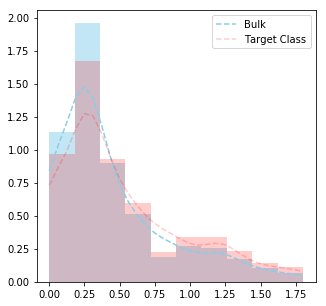

In [10]:
bulkKDE, classKDE = estimate_KD2(ordinals['ps_reg_02'], target, target_class=1, bandwidth=0.1, ax=None, hist_bins=10)

### 3. Use newly implemented class object and its method

In [11]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


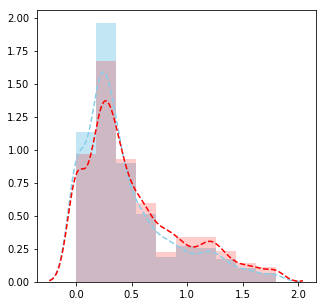

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
kde_bulk = fa.OrdinalFeature(ordinals['ps_reg_02']).estimateKD(bw=0.08, graph=True, ax=ax, hist_bins=10)
kde_class1 = fa.OrdinalFeature(ordinals['ps_reg_02'][target == 1]).estimateKD(bw=0.08, ax=ax, graph=True, hist_bins=10, alpha=0.2, color='red')

In [13]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

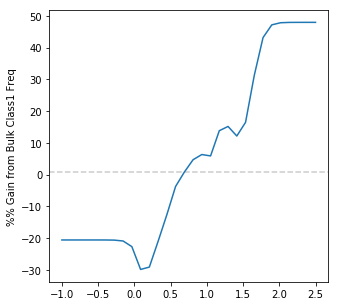

In [14]:
span = np.linspace(-1, 2.5, 30)
probas, gain = ps.compareKDEs(kde_bulk, kde_class1, span, level=class1_freq, label=None, graph=True, ax=None, output='both')

In [15]:
def myOrdinalFeatureAnalaysis1(feature, target, span, bw=0.08, hist_bins=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    kde_bulk = fa.OrdinalFeature(feature).estimateKD(bw=bw, graph=True, ax=ax1, hist_bins=10)
    kde_class1 = fa.OrdinalFeature(feature[target == 1]).estimateKD(
                                            bw=bw, ax=ax1, graph=True, hist_bins=hist_bins, alpha=0.2, color='red')

    ps.compareKDEs(kde_bulk, kde_class1, span, level=class1_freq, 
                                  label=None, graph=True, ax=ax2, output=None)

    plt.tight_layout()

In [45]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

In [46]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


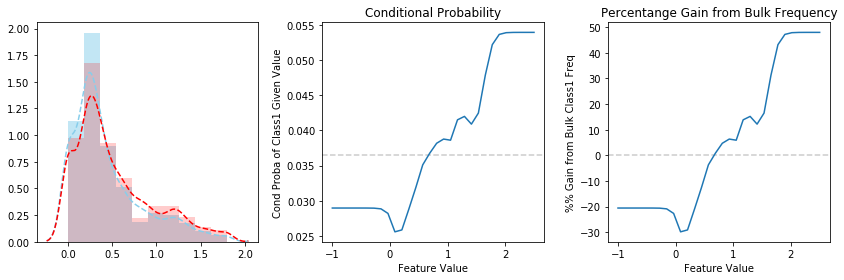

In [41]:
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_reg_02'], target, np.linspace(-1, 2.5, 30), normed=True,
                              level=class1_freq, bw=0.08, hist_bins=10)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


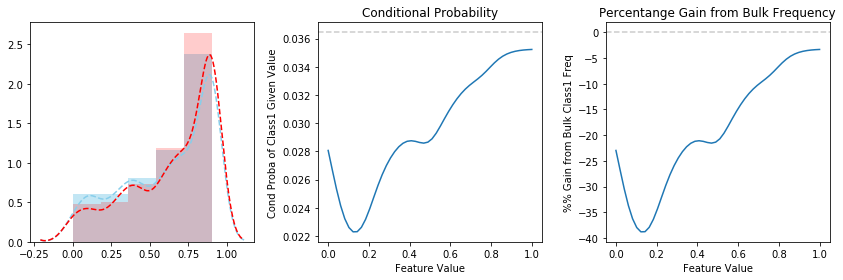

In [54]:
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_reg_01'], target, np.linspace(0, 1, 50), 
                              level=class1_freq, kernel='gau', bw=0.07, hist_bins=5)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


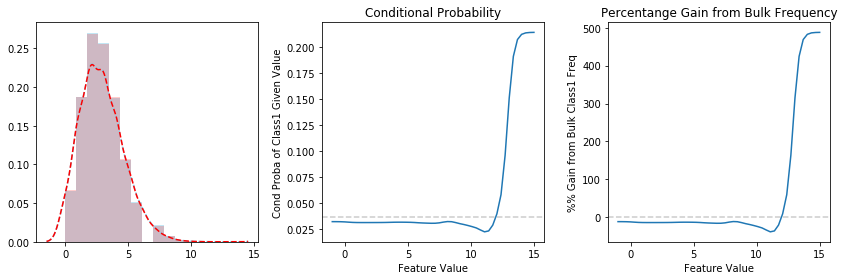

In [26]:
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_calc_13'], target, np.linspace(-1, 15, 50), 
                              level=class1_freq, bw=0.5, hist_bins=15)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


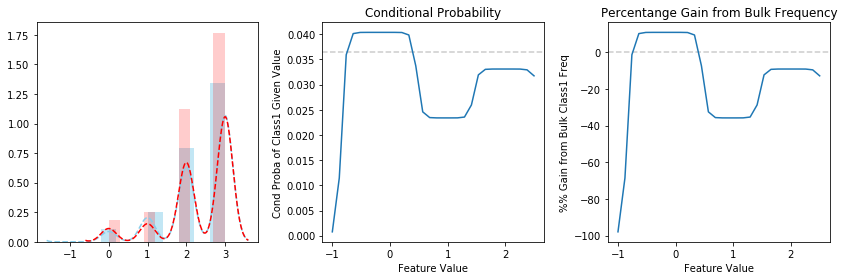

In [61]:
ps.myOrdinalFeatureAnalaysis1(ordinals['ps_car_11'], target, np.linspace(-1, 2.5, 30), 
                              level=class1_freq, bw=0.2, hist_bins=10)

## Comment
The functions I wrote can be useful to analyze the continuous/ordinal feature individually. I additionally need to write a function to conver any value into this 'gain' space for the later processing. It appears that the conditional probability and thus the gain (i.e. its linear transformant) is not so sensitive to the value of bandwidth parameter. So I can probably use visual inspectio to decide on its value. In addition, some of the gain values obtained are slight (though not significantly) off from the digitized version obtained fro contigency tables (e.eg ps_car_11 above). Scaling may or may not be necessary when combined with other features for things like PCA.